In [1]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import PydanticOutputParser
from langchain_community.tools import WikipediaQueryRun, DuckDuckGoSearchRun
from langchain_community.utilities import WikipediaAPIWrapper
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from typing import List, Optional, Dict
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(usecwd=True))

BASE_URL = os.getenv("LITELLM_BASE_URL", "")
API_KEY = os.getenv("LITELLM_API_KEY", "")
MODEL_NAME = os.getenv("MODEL_NAME", "qwen3-32b")

c:\Users\mrtol\Documents\Projects\NLP\nlp-lab-1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LLM():
    def __init__(self):
        self.base_url = BASE_URL
        self.api_key = API_KEY
        self.model = MODEL_NAME
        self.disable_streaming = False
        self.create_connection()

    def create_connection(self, temperature=0.1):
        self.llm = ChatOpenAI(
            base_url=self.base_url,
            api_key=self.api_key,
            model=self.model,
            disable_streaming=self.disable_streaming,
            temperature=temperature
        )

    def invoke(self, system_prompt, human_prompt):
        response = self.llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content=human_prompt)
        ])
        return response.content

llm = LLM()

def retry_with_parser(system_prompt, human_prompt, parser):
    for i in range(1, 4):
        if i > 1:
            print(f"Try {i}")
        try:
            result = llm.invoke(system_prompt, human_prompt)
            parsed = parser.parse(result)
            llm.create_connection()
            return parsed
        except:
            llm.create_connection(temperature=0.1 + i * 0.1)

    print(f"No more retries for {parser}")


def retry(system_prompt, human_prompt):
    for i in range(1, 4):
        if i > 1:
            print(f"Try {i}")
        try:
            result = llm.invoke(system_prompt, human_prompt)
            llm.create_connection()
            return result
        except:
            llm.create_connection(temperature=0.1 + i * 0.1)

    print(f"No more retries for {system_prompt}")


In [3]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
duckduckgo = DuckDuckGoSearchRun()

In [4]:
class PlannerOutput(BaseModel):
    item: str = Field(description="Product name")
    country: str = Field(description="Country of origin")
    target_country: str = Field(description="Target country for finding similar products")

class ProductDescriptionWriterOutput(BaseModel):
    item_description: str = Field(description="Product description")

class ReActThoughtsOutput(BaseModel):
    thoughts: str = Field(description="Current thoughts and reasoning")
    action: str = Field(description="Next action: search_ddg, search_wikipedia, or finish")
    action_input: str = Field(description="Input for the action")
    target_items: List[str] = Field(description="Temporary target items list", default_factory=list)
    evidence: List[str] = Field(description="Collected evidence from searches", default_factory=list)

class ProductRecommenderOutput(BaseModel):
    target_items: List[str] = Field(description="Recommended products")
    taste_similarity: List[float] = Field(description="Taste similarity score")
    use_cases: List[str] = Field(description="Usage scenarios")
    package: List[str] = Field(description="Packaging options")
    search_evidence: List[str] = Field(description="Evidence from search results", default_factory=list)

class ProductCriticOutput(BaseModel):
    target_item: str = Field(description="Selected product")
    selection_reason: str = Field(description="Reason for selection based on search evidence")

class PipelineState(BaseModel):
    human_request: Optional[str] = None
    planner: Optional[PlannerOutput] = None
    product_description_writer: Optional[ProductDescriptionWriterOutput] = None
    product_recommender: Optional[ProductRecommenderOutput] = None
    product_critic: Optional[ProductCriticOutput] = None

planner_parser = PydanticOutputParser(pydantic_object=PlannerOutput)
description_parser = PydanticOutputParser(pydantic_object=ProductDescriptionWriterOutput)
recommender_parser = PydanticOutputParser(pydantic_object=ProductRecommenderOutput)
critic_parser = PydanticOutputParser(pydantic_object=ProductCriticOutput)
react_parser = PydanticOutputParser(pydantic_object=ReActThoughtsOutput)

In [5]:
def build_parser_prompt(task: str, parser: PydanticOutputParser) -> str:
    return f"""
    {task}

    {parser.get_format_instructions()}

    Respond ONLY in the specified format.
    """

In [6]:
def planner(state: PipelineState) -> PipelineState:
    print("Planner:started")

    task = f"""
    Your task: extract information from the user's request. User request: {state.human_request}

    You need to extract:
    1. item - product nameф
    2. country - country of origin of the product
    3. target_country - target country where we are looking for similar products
    """

    prompt = build_parser_prompt(task, planner_parser)
    response_text = retry_with_parser(
        system_prompt="You are an assistant for extracting structured information.",
        human_prompt=prompt,
        parser=planner_parser
    )
    print("Planner:finished")
    print(response_text)

    state.planner = response_text
    return state

In [7]:
def product_description_writer(state: PipelineState) -> PipelineState:
    print("Description_writer:started")

    task = f"""
    Your task: create an enriched product description.

    Product information:
    - Product: {state.planner.item}
    - Country of origin: {state.planner.country}
    - Target country: {state.planner.target_country}

    Requirements for the description:
    1. Emphasize unique product features
    2. Consider consumer preferences in the target country
    3. Description length: 100-150 words
    """

    prompt = build_parser_prompt(task, description_parser)
    response_text = retry_with_parser(
        system_prompt="You are a professional copywriter specializing in creating selling product descriptions for international markets.",
        human_prompt=prompt,
        parser=description_parser
    )

    print("Description_writer:finished")
    print(response_text)

    state.product_description_writer = response_text
    return state

In [8]:
def execute_action(action: str, action_input: str) -> str:
    if action == "search_ddg":
        try:
            return duckduckgo.run(action_input)
        except Exception as e:
            return f"Search failed: {str(e)}"
    elif action == "search_wikipedia":
        try:
            return wikipedia.run(action_input)
        except Exception as e:
            return f"Wikipedia search failed: {str(e)}"
    else:
        return "Unknown action"

def build_react_prompt(state: PipelineState, history: List[Dict[str, str]], observations: List[str]) -> str:
    base_context = f"""
    You are an expert product recommendation specialist. Your task is to find similar products to:

    ORIGINAL PRODUCT: {state.planner.item}
    COUNTRY: {state.planner.country}
    TARGET COUNTRY: {state.planner.target_country}
    PRODUCT DESCRIPTION: {state.product_description_writer.item_description}

    You need to recommend 3-5 similar products for the target country.

    You have access to two tools:
    1. search_ddg: Search the web using DuckDuckGo for current information
    2. search_wikipedia: Search Wikipedia for detailed product information

    Follow the ReAct format:
    1. Think step by step about what information you need
    2. Choose an action (search_ddg, search_wikipedia)
    3. Provide input for the action
    4. Collect evidence from observations and provide it in the answer
    5. Update your target_items list as you find products

    History: {history}
    Observations: {observations}
    """
    return base_context

In [9]:
def react_recommender(state: PipelineState) -> PipelineState:
    print("ReAct_recommender: started")

    history = []
    observation = []
    max_steps = 3
    for step_num in range(max_steps):
        print(f"ReAct Step {step_num + 1}/{max_steps}")

        task = build_react_prompt(state, history, observation)
        prompt = build_parser_prompt(task, react_parser)

        response = retry_with_parser(
            system_prompt="You are a product research assistant.",
            human_prompt=prompt,
            parser=react_parser
        )
        print(response)

        history.append(response)
        observation.append(execute_action(response.action, response.action_input))

    task = build_react_prompt(state, history, observation)
    prompt = build_parser_prompt(task, recommender_parser)
    response = retry_with_parser(
        system_prompt="You are a product recommender. Use the history and observations to summarize ReAct loop",
        human_prompt=prompt,
        parser=recommender_parser
    )

    print("ReAct_recommender: finished")
    state.product_recommender = response
    return state

def product_recommender(state: PipelineState) -> PipelineState:
    try:
        return react_recommender(state)
    except Exception as e:
        print(f"ReAct recommender failed: {e}, using fallback")
        return fallback_recommender(state)

In [10]:
def fallback_recommender(state: PipelineState) -> PipelineState:
    print("Fallback_recommender:started")

    task = f"""
    Your task: based on the product description, provide recommendations for similar products.

    PRODUCT:
    {state.planner.item}
    COUNTRY:
    {state.planner.country}
    TARGET_COUNTRY_FOR_SIMILAR_PRODUCTS:
    {state.planner.target_country}
    PRODUCT DESCRIPTION:
    {state.product_description_writer.item_description}

    Requirements for recommendations:
    1. Suggest 3-5 target products (target_items)
    2. For each product, rate taste similarity from 0.0 to 1.0 (taste_similarity)
    3. For each product, specify usage scenarios (use_cases)
    4. For each product, suggest packaging options (package)
    5. All lists must be the same length

    Example structure:
    - target_items: ["Product A", "Product B", "Product C"]
    - taste_similarity: [0.8, 0.6, 0.9]
    - use_cases: ["For holidays", "For gifts", "For everyday use"]
    - package: ["Gift packaging", "Economy packaging", "Premium packaging"]
    """

    prompt = build_parser_prompt(task, recommender_parser)
    response_text = retry_with_parser(
        system_prompt="You are an expert in product recommendations and merchandising.",
        human_prompt=prompt,
        parser=recommender_parser
    )
    print("Fallback_recommender:finished")
    print(response_text)

    state.product_recommender = response_text
    return state


In [11]:
def product_critic(state: PipelineState) -> PipelineState:
    print("Product_critic:started")

    task = f"""
    Your task: analyze the recommended products and select the most promising one.

    RECOMMENDED PRODUCTS:
    {', '.join(state.product_recommender.target_items)}

    Analysis criteria:
    1. Commercial potential
    2. Uniqueness of the offer
    3. Compliance with the target market
    4. Ease of implementation
    5. Scalability potential
    6. Evidence from search results

    Choose ONE most promising product from the list above and provide reasoning based on search evidence.
    """

    prompt = build_parser_prompt(task, critic_parser)
    response_text = retry_with_parser(
        system_prompt="You are a critic and analyst of product assortment with experience in international trade. Use search evidence to support your selection.",
        human_prompt=prompt,
        parser=critic_parser
    )
    print("Product_critic:finished")
    print(response_text)

    state.product_critic = response_text
    return state


In [12]:
graph = StateGraph(PipelineState)
graph.add_node("planner", planner)
graph.add_node("product_description_writer", product_description_writer)
graph.add_node("product_recommender", product_recommender)
graph.add_node("product_critic", product_critic)

graph.set_entry_point("planner")
graph.add_edge("planner", "product_description_writer")
graph.add_edge("product_description_writer", "product_recommender")
graph.add_edge("product_recommender", "product_critic")
graph.add_edge("product_critic", END)
app = graph.compile()

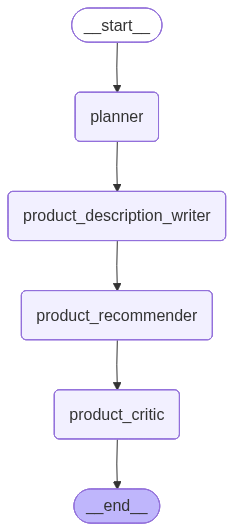

In [13]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [14]:
test_request = "What product in Greece is most similar to Russian pelmeni?"

initial_state = PipelineState(human_request=test_request)

try:
    result = app.invoke(initial_state)
except Exception as e:
    print(f"Error executing pipeline: {e}")

Planner:started
Planner:finished
item='pelmeni' country='Russia' target_country='Greece'
Description_writer:started
Description_writer:finished
item_description='Δοκιμάστε τα παραδοσιακά πέλμενι, τα ρωσικά φλουδοπούλια γεμισμένα με ντόπιο κρέας και χοντρή ζυμή από τη Σιβηρία! Αυτά τα χειροποίητα φαγητά εντυπωσιάζουν με τον φρέσκο γεύση και την ισχυρή γεύση του γεμισμού από χοιρινό ή βοδινό κρέας. Τα πέλμενι είναι τέλεια για γρήγορες, θερμές μερίδες και συνδυάζονται χαριτωμένα με σάλτσα σούπας, παγωμένο γάλα ή ακόμη και τυριά για ένα ελληνικό twist. Προσφέρουμε έτοιμα στη συσκευασία για εύκολη μαγειρική – απλώς βράστε και προσθέστε την προτίμησή σας σε συνταγές. Μια ανακάλυψη για ερασιτέχνες και επαγγελματίες μαγείρες που αναζητούν νέες γεύσεις από την Κεντρική Ασία!'
ReAct_recommender: started
ReAct Step 1/3
thoughts="To find similar products to pelmeni in Greece, I need to identify Greek or neighboring dishes that are filled dough-based, meat-filled, and comparable in preparation/meth